### Классические подходы RecSys

Рассмотрим три подхода: 1. Топ 10 2. Косинусное сходство 3.Понижение размерности SVD

Загрузка данных

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [31]:
df = pd.read_parquet('/Users/idaklimanova/test/data_light.parquet')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   CheckNo    int64 
 1   Item_name  object
dtypes: int64(1), object(1)
memory usage: 61.0+ MB


In [33]:
#  Подсчет количества чеков для каждого товара
item_popularity = df.groupby('Item_name')['CheckNo'].nunique().sort_values(ascending=False)
top_20_items = item_popularity.head(20)
print("Топ-20 самых популярных товаров:")
print(top_20_items)

Топ-20 самых популярных товаров:
Item_name
МОЛОКО                    97887
ХЛЕБ БЕЛЫЙ                77311
ЦИТРУСОВЫЕ                71853
ЯЙЦО КУРИНОЕ              68142
ТОМАТЫ                    66011
БАНАНЫ                    63203
ОГУРЦЫ                    61682
ЯБЛОКИ                    58679
КАРТОФЕЛЬ                 55401
СМЕТАНА                   52705
ТВОРОГ                    48116
МАКАРОННЫЕ ИЗДЕЛИЯ        47507
СЫРЫ ВЕСОВЫЕ              45107
КУРИНЫЙ РАЗРУБ            44497
МАСЛО СЛИВОЧНОЕ           43405
ХЛЕБ РЖАНОЙ               40522
ЛУК                       40021
МОРКОВЬ                   37547
КИСЛОМОЛОЧНЫЕ ПРОДУКТЫ    35849
ПЕЧЕНЬЕ                   33318
Name: CheckNo, dtype: int64


Датасет состоит из 4 000 000 строк и 2 столбцов.
Количество уникальных значенйи Item_name = 1077

С таким вхождением строк естественно думать в сторону pyspark тк pandas вряд ли вытянет(в лоб,проверено,что нет).
Но можно попробовать подход, чтоб развернуть наши Item_name и перевести их фичи. На выходе у нас будет датасет с количесвом колонок, равным уникальным значениям Item_name. Это некий аналог onehotencoding.
Безусловно, мы раздуваем пространство размерностей таким образом, но потребляемая память равна 2.5 гб, что приемлено против 4 млн строк.

In [ ]:
# Шаг 2: Очистка данных - замена пробелов, запятых и точек на подчеркивания
df['Item_name_clean'] = df['Item_name'].str.replace(r'[ ,.]', '_', regex=True)


In [34]:
df_dum = pd.get_dummies(df['Item_name']).groupby(df['CheckNo']).sum()

In [35]:
df_dum.head(3)

,АВОКАДО,АВТО И КОМПЬЮТЕРНЫЕ ЖУРНАЛЫ,АВТОПРИНАДЛЕЖНОСТИ АКСЕССУАРЫ ДЛЯ УБОРКИ,АВТОПРИНАДЛЕЖНОСТИ АКСЕССУАРЫ ПРОЧИЕ,АВТОХИМИЯ СИНТЕТИЧЕСКИЕ ВЕЩЕСТВА,АДЖАПСАНДАЛИ,АДЖИКА,АКСЕССУАРЫ,АКССЕСУАРЫ ДЛЯ СТИРКИ,АНАНАСЫ,...,ЭНЕРГЕТИКИ,ЭТНИЧЕСКИЕ КРУПЫ,ЯБЛОКИ,ЯГОДЫ,ЯЗЫК ГОВЯЖИЙ ЗАЛИВНОЙ,ЯЗЫК ГОВЯЖИЙ ОТВАРНОЙ,ЯИЧНАЯ ПРОДУКЦИЯ,ЯЙЦО КУРИНОЕ,ЯЙЦО ПЕРЕПЕЛИНОЕ,ЯЙЦО ФЕРМЕРСКОЕ
CheckNo,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Теперь можно пробовать классические подходы.

Размер датасета изменился - теперь 306777 entries rows × 1076 columns.
-dtypes: int64(1076)
-memory usage: 2.5 GB

Импортируем кастомные функции и метрики

In [36]:
import recsys_preprocessing

In [37]:
from recsys_preprocessing import precision_at_k,recall_at_k,average_precision_at_k
from recsys_preprocessing import recommend_categories_top,evaluate_recommendations_top_10

Визуализация

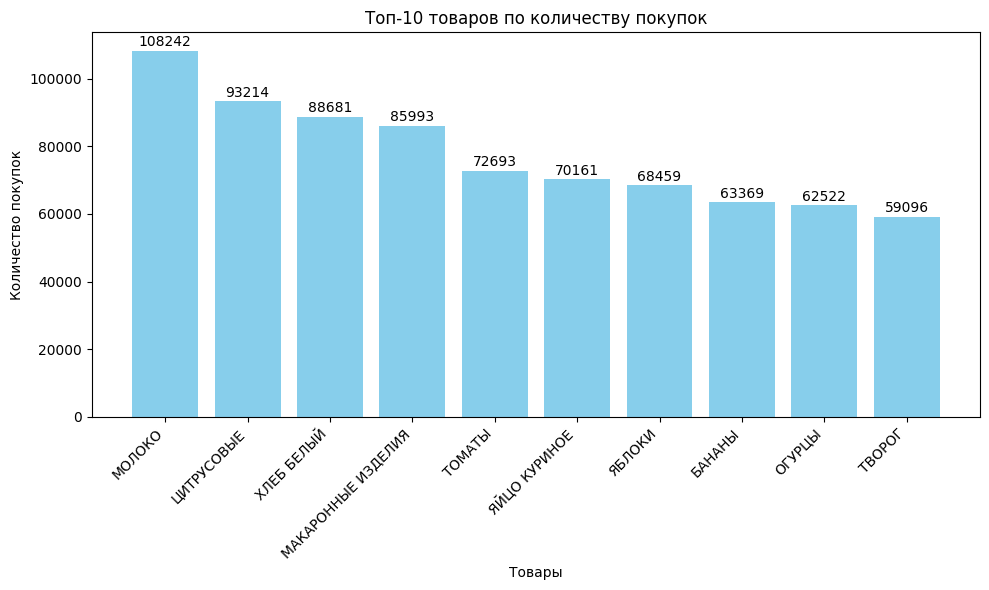

In [38]:
import matplotlib.pyplot as plt

# Подсчет количества покупок для каждого товара
item_sum = df.groupby('Item_name')['CheckNo'].count()

# Сортировка и выбор топ-10 товаров
top_item = item_sum.sort_values(ascending=False)
top_10_item = top_item.head(10)

# Создание графика
plt.figure(figsize=(10, 6))
bars = plt.bar(top_10_item.index, top_10_item.values, color='skyblue')

# Подписи к столбцам
plt.title('Топ-10 товаров по количеству покупок')
plt.xlabel('Товары')
plt.ylabel('Количество покупок')
plt.xticks(rotation=45, ha='right')

# Отображение значений на вершине каждого столбца
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, int(yval), ha='center', va='bottom', color='black')

# Автоматическая настройка отступов
plt.tight_layout()

# Отображение графика
plt.show()


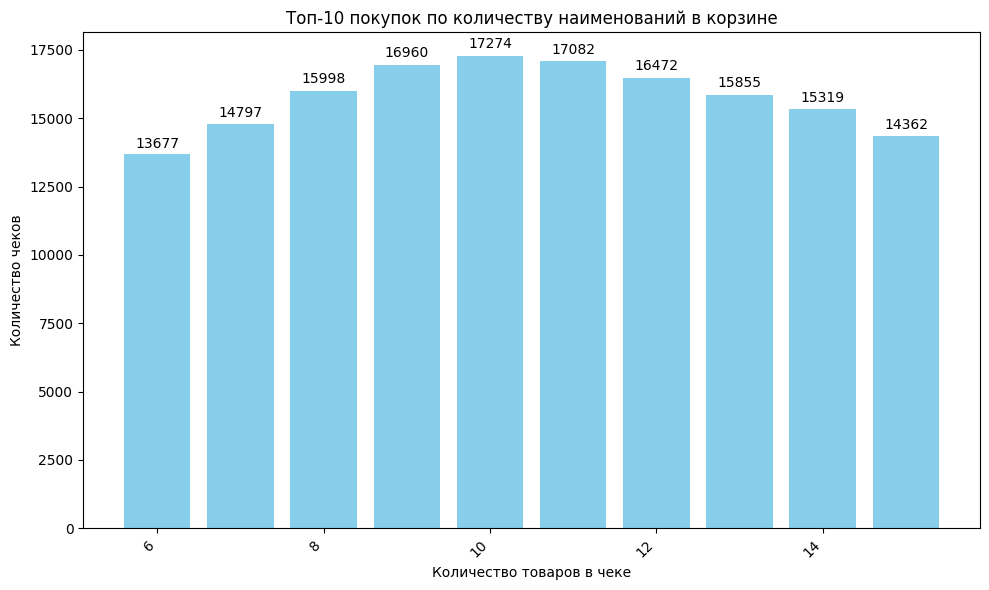

In [39]:
# Количество товаров в 1 покупке
count_products = df.groupby('CheckNo')['Item_name'].count()  # группировка по чеку
group_by_count_in_check = count_products.groupby(count_products).count().sort_values(ascending=False)
group_by_count_in_check_10 = group_by_count_in_check.head(10)

# Создание графика с названиями категорий
plt.figure(figsize=(10, 6))
bars = plt.bar(group_by_count_in_check_10.index, group_by_count_in_check_10.values, color='skyblue')

# Подписи к столбцам
plt.title('Топ-10 покупок по количеству наименований в корзине')
plt.xlabel('Количество товаров в чеке')
plt.ylabel('Количество чеков')
plt.xticks(rotation=45, ha='right')

# Отображение значений на вершине каждого столбца
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + yval * 0.01, int(yval), ha='center', va='bottom', color='black')

# Автоматическая настройка отступов
plt.tight_layout()

# Отображение графика
plt.show()


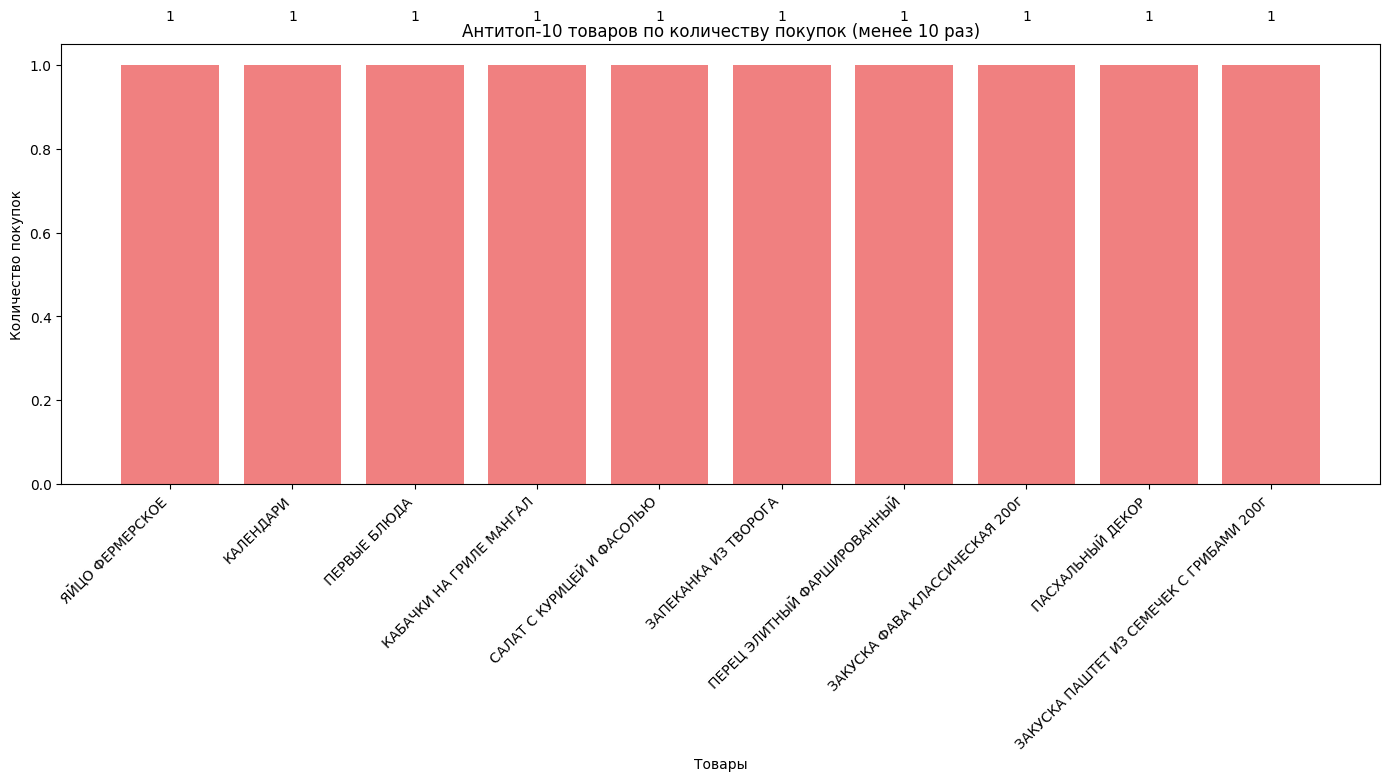

In [40]:
# Выбор товаров, которые были куплены менее 10 раз
less_than_10_item = item_sum[item_sum < 10].sort_values(ascending=True)

# Выбор 10 самых непопулярных товаров
least_popular_10_item = less_than_10_item.head(10)

# Создание графика для 10 самых непопулярных товаров
plt.figure(figsize=(14, 8))
bars = plt.bar(least_popular_10_item.index, least_popular_10_item.values, color='lightcoral',label='Товары')

# Подписи к столбцам
plt.title('Антитоп-10 товаров по количеству покупок (менее 10 раз)')
plt.xlabel('Товары')
plt.ylabel('Количество покупок')
plt.xticks(rotation=45, ha='right')

# Отображение значений на вершине каждого столбца
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom', color='black')


# Автоматическая настройка отступов
plt.tight_layout()

# Отображение графика
plt.show()

## Часть 1.ТОП 10

Плюсы:

Простота реализации.
Основан на частоте совместных покупок, что может быть интуитивным для понимания рекомендаций.
Минусы:

Не учитывает относительную "схожесть" между категориями. Категории могут встречаться вместе просто потому, что они популярны.

In [41]:
df_dum = pd.get_dummies(df['Item_name']).groupby(df['CheckNo']).sum()

In [43]:
# Пример вызова функции
recommended_categories = recommend_categories_top('АВТО И КОМПЬЮТЕРНЫЕ ЖУРНАЛЫ', df_dum, top_n=10)
print("Рекомендованные категории:", recommended_categories)

Рекомендованные категории: ['САДОВЫЙ ИНВЕНТАРЬ', 'КОНФЕТЫ ШОКОЛАДНЫЕ', 'ЯЙЦО КУРИНОЕ', 'КОФЕ НАТУРАЛЬНЫЙ', 'ХЛЕБ РЖАНОЙ', 'ПОМОЩЬ ПИЩЕВАРЕНИЮ', 'КОЛБАСА ВАРЕНАЯ', 'ТОМАТЫ', 'СУФЛЕ', 'СПЕЦИИ,ПРИПРАВА']


## Часть 2.Косинусное сходство

Подход с косинусным сходством измеряет схожесть между двумя категориями по углу между их векторами в многомерном пространстве. Косинусное сходство варьируется от -1 до 1, где 1 означает идеальную схожесть, 0 означает отсутствие схожести, а -1 означает противоположные векторы.

Плюсы:

Более чувствителен к структуре данных.
Учитывает "схожесть" между категориями, а не просто их совместную встречаемость.
Минусы:

Более сложен для интерпретации и может не всегда соответствовать интуитивным ожиданиям.

In [46]:
from sklearn.metrics.pairwise import cosine_similarity
from recsys_preprocessing import evaluate_recommendations_cos

In [48]:
#  Разделяем данные на тренировочные и тестовые
train_df, test_df = train_test_split(df_dum, test_size=0.2, random_state=42)

# Подсчет косинусной близости между категориями товаров
category_similarity = cosine_similarity(df_dum.T)
# матрицу нужно транспонировать тк мы работаем с рекомендациями на основе фичей, а не юзеров(чеков)
# Преобразуем результат в DataFrame для удобства
category_sim_df = pd.DataFrame(category_similarity, index=df_dum.columns, columns=df_dum.columns)

# Получаем рекомендации для конкретной категории
def recommend_categories_cos(item_name, similarity_matrix, top_n=10):
    similar_items = similarity_matrix[item_name].sort_values(ascending=False)
    return similar_items.index[1:top_n+1]  # Пропускаем саму категорию

In [49]:
# Список категорий, для которых нужно получить рекомендации - визуальный осмотр
categories_to_check = ['ТВОРОГ', 'АВТО И КОМПЬЮТЕРНЫЕ ЖУРНАЛЫ', 'АДЖИКА']
for category in categories_to_check:
    recommendations = recommend_categories_cos(category, category_sim_df)
    print(f"Рекомендации для категории '{category}': {recommendations}")
    print("-" * 50)

Рекомендации для категории 'ТВОРОГ': Index(['СМЕТАНА', 'МОЛОКО', 'КИСЛОМОЛОЧНЫЕ ПРОДУКТЫ', 'ЯЙЦО КУРИНОЕ', 'БАНАНЫ',
       'ЯБЛОКИ', 'ЦИТРУСОВЫЕ', 'ХЛЕБ БЕЛЫЙ', 'ТОМАТЫ', 'ОГУРЦЫ'],
      dtype='object')
--------------------------------------------------
Рекомендации для категории 'АВТО И КОМПЬЮТЕРНЫЕ ЖУРНАЛЫ': Index(['ДЕЛОВЫЕ ЖУРНАЛЫ', 'СУФЛЕ', 'САДОВЫЙ ИНВЕНТАРЬ', 'ТОРТЫ СЛОЕНЫЕ',
       'ДЕТСКИЕ МОЛОЧНЫЕ ПРОДУКТЫ МОЛОКО', 'КОФЕ НАТУРАЛЬНЫЙ',
       'ЦВЕТЫ УДОБРЕНИЯ/ГРУНТ', 'БАКЛАЖАНЫ', 'НАГГЕТСЫ', 'ЧАЙ ТРАВЯНОЙ'],
      dtype='object')
--------------------------------------------------
Рекомендации для категории 'АДЖИКА': Index(['ТОМАТНАЯ ПАСТА', 'СОУСЫ НА ТОМАТНОЙ ОСНОВЕ', 'СПЕЦИИ,ПРИПРАВА',
       'ГОРЧИЦА', 'ЛУК', 'КЕТЧУПЫ', 'ХРЕН', 'ПРОЧИЕ СОУСЫ', 'СМЕТАНА',
       'СОУСЫ ФРУКТОВЫЕ,ЯГОДНЫЕ'],
      dtype='object')
--------------------------------------------------


In [50]:
# Оценка метрик для разных значений top_n
for top_n in [3, 5, 10]:
    print(f'\nОценка метрик для top_n={top_n}:')
    mean_precision, mean_recall, mean_map = evaluate_recommendations_cos(test_df, category_sim_df, top_n)


Оценка метрик для top_n=3:
Средняя Precision@3: 0.23783904223117092
Средняя Recall@3: 0.06812046924808549
Средняя MAP@3: 0.1868271462032161

Оценка метрик для top_n=5:
Средняя Precision@5: 0.22103787273586906
Средняя Recall@5: 0.10203544350695432
Средняя MAP@5: 0.15455310642660855

Оценка метрик для top_n=10:
Средняя Precision@10: 0.19720234116438692
Средняя Recall@10: 0.172869239415867
Средняя MAP@10: 0.1259667726251396


Смотрим на recall если приоритет — показать пользователю большее разнообразие товаров

MAP полезен, если важна не только точность рекомендаций, но и их порядок — более релевантные элементы должны стоять выше в списке рекомендаций

Метрики в задаче рекомендательных систем не всегда являются высокими и стоит также принять во внимание другие критерии, как резульаты АБ тестирований, проведенных на части трафика; опрос удовлетворенности клиентов итд

In [51]:
import pickle

# Предположим, у вас уже есть матрица схожести category_sim_df
# Например, она была создана так:
# category_sim_df = pd.DataFrame(cosine_similarity(df_dum.T), index=df_dum.columns, columns=df_dum.columns)

# Сохранение матрицы в файл
with open("/Users/idaklimanova/test/category_similarity_matrix.pkl", "wb") as f:
    pickle.dump(category_sim_df, f)

print("Матрица схожести сохранена успешно.")


Матрица схожести сохранена успешно.


## Часть 3. SVD

Попробуем уменьшить размерность данных.

In [52]:
from sklearn.decomposition import TruncatedSVD
from recsys_preprocessing import recommend_categories_svd,evaluate_recommendations_svd

In [53]:


# Пример создания разреженной матрицы взаимодействий (категории по чекам)
df_svd = pd.get_dummies(df['Item_name']).groupby(df['CheckNo']).sum()

# Применяем SVD для уменьшения размерности
svd = TruncatedSVD(n_components=40, random_state=42)
latent_matrix = svd.fit_transform(df_svd)

# Реконструируем матрицу взаимодействий
reconstructed_matrix = np.dot(latent_matrix, svd.components_)

# Преобразуем результат в DataFrame без транспонирования (категории остаются столбцами)
reconstructed_df = pd.DataFrame(reconstructed_matrix, index=df_svd.index, columns=df_svd.columns) 

# Косинусное сходство между категориями для создания рекомендаций
from sklearn.metrics.pairwise import cosine_similarity
category_similarity = cosine_similarity(reconstructed_df.T)  # Транспонируем для сравнения категорий
category_sim_df = pd.DataFrame(category_similarity, index=df_svd.columns, columns=df_svd.columns)

# Пример вызова функции
recommended_categories = recommend_categories_svd('АВТО И КОМПЬЮТЕРНЫЕ ЖУРНАЛЫ', category_sim_df)
print("Рекомендованные категории:", recommended_categories)


Рекомендованные категории: ['САДОВЫЙ ИНВЕНТАРЬ', 'ЦВЕТЫ РАССАДА', 'ЦВЕТЫ УДОБРЕНИЯ/ГРУНТ', 'ДЕЛОВЫЕ ЖУРНАЛЫ', 'ДЕТСКИЕ СЕЗОННЫЙ АССОРТИМЕНТ', 'МОЙВА ЖАРЕНАЯ', 'УХОД ЗА КОЖЕЙ СРЕДСТВА ДЛЯ УХОДА ЗА ТЕЛОМ', 'КОФЕЙНАЯ,ЧАЙНАЯ ПОСУДА', 'ПЕЛЬМЕНИ ЗАМОРОЖЕННЫЕ', 'КУХОННАЯ ПОСУДА']


In [54]:
categories_to_check = ['ТВОРОГ', 'АВТО И КОМПЬЮТЕРНЫЕ ЖУРНАЛЫ', 'АДЖИКА']
for category in categories_to_check:
    recommendations = recommend_categories_cos(category, category_sim_df)
    print(f"Рекомендации для категории '{category}': {recommendations}")
    print("-" * 50)

Рекомендации для категории 'ТВОРОГ': Index(['ЗОЖ СУХИЕ ЗАВТРАКИ', 'ЯИЧНАЯ ПРОДУКЦИЯ', 'ШПИКАЧКИ',
       'ЗОЖ ДЖЕМЫ, СИРОПЫ, ПАСТА',
       'ДИЕТИЧЕСКОЕ ПИТАНИЕ МУЧНЫЕ ДИАБЕТИЧЕСКИЕ ПРОДУКТЫ', 'ПАСТИЛА',
       'ХУМУС SABABA ЧИЛИ ПИКАНТНЫЙ 300г', 'ДИЕТИЧЕСКОЕ ПИТАНИЕ ДЖЕМЫ',
       'ВАРЕНЬЕ,ДЖЕМ,КОНФИТЮР,ПОВИДЛО',
       'ДИЕТИЧЕСКОЕ ПИТАНИЕ САХАРОЗАМЕНИТЕЛЬ'],
      dtype='object')
--------------------------------------------------
Рекомендации для категории 'АВТО И КОМПЬЮТЕРНЫЕ ЖУРНАЛЫ': Index(['САДОВЫЙ ИНВЕНТАРЬ', 'ЦВЕТЫ РАССАДА', 'ЦВЕТЫ УДОБРЕНИЯ/ГРУНТ',
       'ДЕЛОВЫЕ ЖУРНАЛЫ', 'ДЕТСКИЕ СЕЗОННЫЙ АССОРТИМЕНТ', 'МОЙВА ЖАРЕНАЯ',
       'УХОД ЗА КОЖЕЙ СРЕДСТВА ДЛЯ УХОДА ЗА ТЕЛОМ', 'КОФЕЙНАЯ,ЧАЙНАЯ ПОСУДА',
       'ПЕЛЬМЕНИ ЗАМОРОЖЕННЫЕ', 'КУХОННАЯ ПОСУДА'],
      dtype='object')
--------------------------------------------------
Рекомендации для категории 'АДЖИКА': Index(['ГОРЧИЦА', 'ТОМАТНАЯ ПАСТА', 'ХРЕН', 'СОУСЫ ФРУКТОВЫЕ,ЯГОДНЫЕ',
       'ПАНИРОВОЧНАЯ СМЕСЬ', 'ТОМАТЫ КОНСЕРВИРОВА

При повышении n_components=40 - сохраняется больше информации из исходных данных.
При этом метрики падают,но визуальный анализ указывает на очень плотную связь с категорией - рекомендации очень близкие по значению.
Интуитивно можно оставить высокое значение n_components, но треть рекомендаций заменить на рандомные товары топ 20 бестселлеры

Посмотрим метрики

In [55]:
#  Разделяем данные на тренировочные и тестовые
train_df, test_df = train_test_split(df_dum, test_size=0.2, random_state=42)
# Вызываем функцию для оценки метрик на тестовом наборе
top_k = 10
mean_precision, mean_recall, mean_map = evaluate_recommendations_svd(test_df, category_sim_df, top_k)

# Оцениваем качество рекомендаций
evaluate_recommendations_svd(test_df, category_sim_df, top_k=10)

Средняя Precision@10: 0.04092146665145019
Средняя Recall@10: 0.04034063980604921
Средняя MAP@10: 0.024484216531502914
Средняя Precision@10: 0.040963855421686755
Средняя Recall@10: 0.04027323153269949
Средняя MAP@10: 0.02437499970989526


(0.040963855421686755, 0.04027323153269949, 0.02437499970989526)

при n = 50 
Средняя Precision@10: 0.007355032206431964
Средняя Recall@10: 0.019541926606411644
Средняя MAP@10: 0.008232960982414333

при n = 100
Средняя Precision@5: 0.0056627376632660195
Средняя Recall@5: 0.007688598370141501
Средняя MAP@5: 0.004520303951708915

## Сохранение весов

In [56]:
# import pickle
# # Сохранение матрицы в файл
# with open("category_similarity_matrix.pkl", "wb") as f:
#     pickle.dump(category_sim_df, f)

# print("Матрица схожести сохранена успешно.")

# import joblib

# # Сохранение модели SVD
# joblib.dump(svd, 'svd_model.pkl')

# # Сохранение реконструированной матрицы
# reconstructed_df.to_pickle('reconstructed_df.pkl')

# # Сохранение матрицы схожести категорий
# category_sim_df.to_pickle('category_similarity_matrix2.pkl')

# print("Модель SVD, реконструированная матрица и матрица схожести категорий успешно сохранены.")
